Fit results saved to fit_results_EE_2hlt1.root


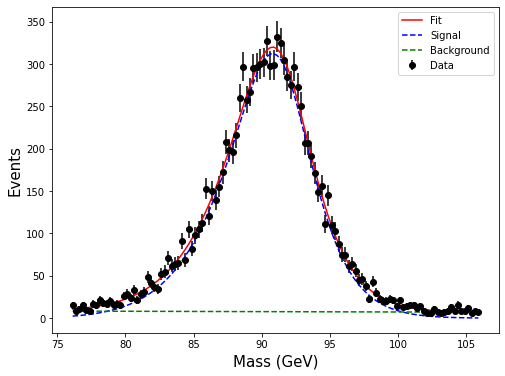

error value saved to eN_2hee1.txt
value saved to N_2hee1.txt


In [1]:
import uproot
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import cauchy, norm
import matplotlib.pyplot as plt

# Load histogram data
root_file_path = "mass_regionEE_hlt.root"
with uproot.open(root_file_path) as file:
    hist = file["h_mass_2hlt_EE_hist1;1"]
    hist_values, hist_edges = hist.to_numpy()

# Calculate x-data (bin centers) and normalize y-data
x_data = (hist_edges[:-1] + hist_edges[1:]) / 2
y_data = hist_values
y_errors = np.sqrt(y_data)  # Assume Poisson statistics for errors

# Define the convoluted signal model (Breit-Wigner + Gaussian)
def convoluted_signal(x, m, gamma, mu, sigma):
    bw = cauchy.pdf(x, loc=m, scale=gamma)  # Breit-Wigner
    gauss = norm.pdf(x, loc=mu, scale=sigma)  # Gaussian
    conv = bw * gauss  # Approximate convolution
    conv /= np.sum(conv)  # Normalize
    return conv

# Exponential background model
def exponential_background(x, a, b):
    return a * np.exp(b * x)

# Combined fit function
def fit_function(x, m, gamma, mu, sigma, a, b, sig_yield):
    signal = convoluted_signal(x, m, gamma, mu, sigma) * sig_yield
    background = exponential_background(x, a, b)
    return signal + background

# Initial guesses for fit parameters
total_yield = np.sum(y_data)
signal_fraction_guess = 0.95
signal_yield_guess = total_yield * signal_fraction_guess
background_yield_guess = total_yield * (1 - signal_fraction_guess)

initial_params = [
    91.1876,  # m
    2.4952,   # gamma
    91.0,     # mu
    2.0,      # sigma
    1.0,      # a
    -0.01,    # b
    signal_yield_guess  # sig_yield
]

# Parameter bounds
bounds = (
    [90, 0.5, 85, 0.1, 0.0, -0.5, 0],  # Lower bounds
    [94, 5.5, 94, 7.0, np.inf, 1.0, total_yield * 1.5]  # Upper bounds
)

# Perform the fit
popt, pcov = curve_fit(
    fit_function, x_data, y_data, p0=initial_params, sigma=y_errors, bounds=bounds
)

# Extract fit parameters and their errors
(m, gamma, mu, sigma, a, b, sig_yield) = popt
sig_yield_error = np.sqrt(pcov[6, 6]) if len(pcov) > 6 else 0.0  # Error for signal yield

# Save signal yield and error to a ROOT file
output_file_path = "fit_results_EE_2hlt1.root"

# Prepare data for ROOT file
fit_results = {
    "signal_yield": [sig_yield],
    "signal_error": [sig_yield_error],
    "background_yield": [a],
    "background_error": [np.sqrt(pcov[4, 4])] if len(pcov) > 4 else [0.0],
}

# Write results to a ROOT file using uproot
with uproot.recreate(output_file_path) as root_file:
    root_file["fit_results"] = {
        "signal_yield": np.array(fit_results["signal_yield"], dtype=np.float64),
        "signal_error": np.array(fit_results["signal_error"], dtype=np.float64),
        "background_yield": np.array(fit_results["background_yield"], dtype=np.float64),
        "background_error": np.array(fit_results["background_error"], dtype=np.float64),
    }
print(f"Fit results saved to {output_file_path}")

# Optional: Plot the fit
signal = convoluted_signal(x_data, m, gamma, mu, sigma) * sig_yield
background = exponential_background(x_data, a, b)
fit = signal + background

plt.figure(figsize=(8, 6))
plt.errorbar(x_data, y_data, yerr=y_errors, fmt='o', label='Data', color='black')
plt.plot(x_data, fit, label='Fit', color='red')
plt.plot(x_data, signal, '--', label='Signal', color='blue')
plt.plot(x_data, background, '--', label='Background', color='green')
plt.xlabel("Mass (GeV)" , fontsize=15)
plt.ylabel("Events" , fontsize=15)
plt.legend()
plt.show()
with open("eN_2hee1.txt", "w") as file:
    file.write(f"{sig_yield_error}\n")
    print("error value saved to eN_2hee1.txt")
with open("N_2hee1.txt", "w") as file:
    file.write(f"{sig_yield}\n")
    print("value saved to N_2hee1.txt")

Signal Yield: 9135.45 ± 142.93
Background Yield: 30.57 ± 22.38
Background Slope: -0.02 ± 0.01
Chi-squared: 147.84
Degrees of Freedom: 113
Chi-squared per dof: 1.31


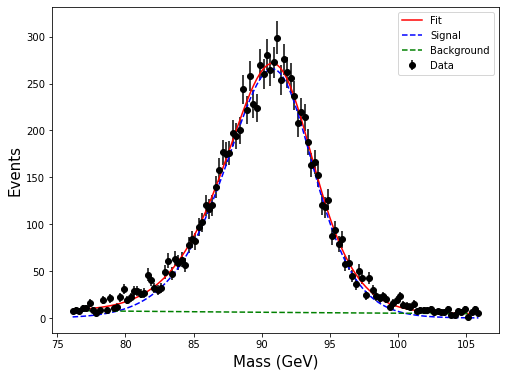

error value saved to eN_2hee2.txt
value saved to N_2hee2.txt


In [2]:
###best and final 1 ###

import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import cauchy, norm

# Load histogram data
root_file_path = "mass_regionEE_hlt.root"
with uproot.open(root_file_path) as file:
    hist = file["h_mass_2hlt_EE_hist2;1"]
    hist_values, hist_edges = hist.to_numpy()

# Calculate x-data (bin centers) and normalize y-data
x_data = (hist_edges[:-1] + hist_edges[1:]) / 2
y_data = hist_values
y_errors = np.sqrt(y_data)  # Assume Poisson statistics for errors

# Define the convoluted signal model (Breit-Wigner + Gaussian)
def convoluted_signal(x, m, gamma, mu, sigma):
    # Breit-Wigner (Cauchy PDF)
    bw = cauchy.pdf(x, loc=m, scale=gamma)
    # Gaussian (Normal distribution)
    gauss = norm.pdf(x, loc=mu, scale=sigma)
    # Convolution approximation (pointwise multiplication, normalize after)
    conv = bw * gauss
    conv /= np.sum(conv)  # Normalize over entire range
    return conv

# Exponential background model (with varying slope)
def exponential_background(x, a, b):
    # a: Exponential normalization (background yield)
    # b: Exponential slope (background decay)
    return a * np.exp(b * x)

# Define the complete fit function for both signal and background
def fit_function(x, m, gamma, mu, sigma, a, b, sig_yield):
    # Signal model
    signal = convoluted_signal(x, m, gamma, mu, sigma)
    signal *= sig_yield  # Scale signal by signal yield

    # Exponential background model (with varying slope)
    background = exponential_background(x, a, b)
    
    # Combine signal and background
    return signal + background

# Total number of events in the histogram
total_yield = np.sum(y_data)  
signal_fraction_guess = 0.95  # Increase signal fraction guess (e.g., 0.95 or 0.9)
signal_yield_guess = total_yield * signal_fraction_guess
background_yield_guess = total_yield * (1 - signal_fraction_guess)

# Initial Parameters (signal and background yield fixed)
initial_params = [
    91.1876,  # m: Breit-Wigner mass
    2.4952,   # gamma: Breit-Wigner width
    91.0,     # mu: Gaussian mean
    2.0,      # sigma: Gaussian standard deviation
    1.0,      # a: Exponential constant term (background normalization)
    -0.01,    # b: Exponential slope (background decay)
    signal_yield_guess,   # sig_yield: Signal yield
]

# Bounds for Parameters (background yield and slope are allowed to vary)
bounds = (
    [90, 0.5, 85, 0.1, 0.0, -0.5, 0],  # Lower bounds
    [94, 5.5, 94, 5.0, np.inf, 1.0, total_yield * 1.5]  # Upper bounds
)

# Fit the data
popt, pcov = curve_fit(
    fit_function, x_data, y_data, p0=initial_params, sigma=y_errors, bounds=bounds
)

# Extracting the fitted parameters
(m, gamma, mu, sigma, a, b, sig_yield) = popt

# Compute errors in the fit parameters
sig_yield_error = np.sqrt(pcov[6, 6])  # Error for sig_yield (7th parameter)
background_error = np.sqrt(pcov[4, 4])  # Error for background (5th parameter)

# Print the results
print(f"Signal Yield: {sig_yield:.2f} ± {sig_yield_error:.2f}")
print(f"Background Yield: {a:.2f} ± {background_error:.2f}")
print(f"Background Slope: {b:.2f} ± {np.sqrt(pcov[5, 5]):.2f}")

# Generate the signal and background components for plotting
signal = convoluted_signal(x_data, m, gamma, mu, sigma)
signal *= sig_yield

background = exponential_background(x_data, a, b)

# Generate the fit curve
fit = signal + background

# Compute the Chi-squared value
residuals = (y_data - fit) / y_errors  # Residuals
chi_squared = np.sum(residuals**2)  # Chi-squared value
dof = len(x_data) - len(popt)  # Degrees of freedom
chi_squared_dof = chi_squared / dof  # Chi-squared per dof

# Print Chi-squared and Degrees of Freedom
print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"Chi-squared per dof: {chi_squared_dof:.2f}")



# Diagnostic plot of the fit
plt.figure(figsize=(8, 6))
plt.errorbar(x_data, y_data, yerr=y_errors, fmt='o', label='Data', color='black')
plt.plot(x_data, fit, label='Fit', color='red')
plt.plot(x_data, signal, '--', label='Signal', color='blue')
plt.plot(x_data, background, '--', label='Background', color='green')
plt.xlabel("Mass (GeV)" , fontsize=15)
plt.ylabel("Events" , fontsize=15)
plt.legend()
plt.show()
with open("eN_2hee2.txt", "w") as file:
    file.write(f"{sig_yield_error}\n")
    print("error value saved to eN_2hee2.txt")
with open("N_2hee2.txt", "w") as file:
    file.write(f"{sig_yield}\n")
    print("value saved to N_2hee2.txt")

Signal Yield: 7624.64 ± 125.92
Background Yield: 13.02 ± 8.67
Background Slope: -0.01 ± 0.01
Chi-squared: 128.55
Degrees of Freedom: 113
Chi-squared per dof: 1.14


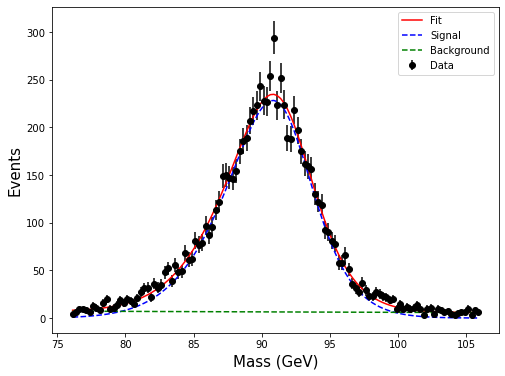

error value saved to eN_2hee3.txt
value saved to N_2hee3.txt


In [3]:
###best and final 1 ###

import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import cauchy, norm

# Load histogram data
root_file_path = "mass_regionEE_hlt.root"
with uproot.open(root_file_path) as file:
    hist = file["h_mass_2hlt_EE_hist3;1"]
    hist_values, hist_edges = hist.to_numpy()

# Calculate x-data (bin centers) and normalize y-data
x_data = (hist_edges[:-1] + hist_edges[1:]) / 2
y_data = hist_values
y_errors = np.sqrt(y_data)  # Assume Poisson statistics for errors

# Define the convoluted signal model (Breit-Wigner + Gaussian)
def convoluted_signal(x, m, gamma, mu, sigma):
    # Breit-Wigner (Cauchy PDF)
    bw = cauchy.pdf(x, loc=m, scale=gamma)
    # Gaussian (Normal distribution)
    gauss = norm.pdf(x, loc=mu, scale=sigma)
    # Convolution approximation (pointwise multiplication, normalize after)
    conv = bw * gauss
    conv /= np.sum(conv)  # Normalize over entire range
    return conv

# Exponential background model (with varying slope)
def exponential_background(x, a, b):
    # a: Exponential normalization (background yield)
    # b: Exponential slope (background decay)
    return a * np.exp(b * x)

# Define the complete fit function for both signal and background
def fit_function(x, m, gamma, mu, sigma, a, b, sig_yield):
    # Signal model
    signal = convoluted_signal(x, m, gamma, mu, sigma)
    signal *= sig_yield  # Scale signal by signal yield

    # Exponential background model (with varying slope)
    background = exponential_background(x, a, b)
    
    # Combine signal and background
    return signal + background

# Total number of events in the histogram
total_yield = np.sum(y_data)  
signal_fraction_guess = 0.95  # Increase signal fraction guess (e.g., 0.95 or 0.9)
signal_yield_guess = total_yield * signal_fraction_guess
background_yield_guess = total_yield * (1 - signal_fraction_guess)

# Initial Parameters (signal and background yield fixed)
initial_params = [
    91.1876,  # m: Breit-Wigner mass
    2.4952,   # gamma: Breit-Wigner width
    91.0,     # mu: Gaussian mean
    2.0,      # sigma: Gaussian standard deviation
    1.0,      # a: Exponential constant term (background normalization)
    -0.01,    # b: Exponential slope (background decay)
    signal_yield_guess,   # sig_yield: Signal yield
]

# Bounds for Parameters (background yield and slope are allowed to vary)
bounds = (
    [90, 0.5, 85, 0.1, 0.0, -0.5, 0],  # Lower bounds
    [94, 5.5, 94, 5.0, np.inf, 1.0, total_yield * 1.5]  # Upper bounds
)

# Fit the data
popt, pcov = curve_fit(
    fit_function, x_data, y_data, p0=initial_params, sigma=y_errors, bounds=bounds
)

# Extracting the fitted parameters
(m, gamma, mu, sigma, a, b, sig_yield) = popt

# Compute errors in the fit parameters
sig_yield_error = np.sqrt(pcov[6, 6])  # Error for sig_yield (7th parameter)
background_error = np.sqrt(pcov[4, 4])  # Error for background (5th parameter)

# Print the results
print(f"Signal Yield: {sig_yield:.2f} ± {sig_yield_error:.2f}")
print(f"Background Yield: {a:.2f} ± {background_error:.2f}")
print(f"Background Slope: {b:.2f} ± {np.sqrt(pcov[5, 5]):.2f}")

# Generate the signal and background components for plotting
signal = convoluted_signal(x_data, m, gamma, mu, sigma)
signal *= sig_yield

background = exponential_background(x_data, a, b)

# Generate the fit curve
fit = signal + background

# Compute the Chi-squared value
residuals = (y_data - fit) / y_errors  # Residuals
chi_squared = np.sum(residuals**2)  # Chi-squared value
dof = len(x_data) - len(popt)  # Degrees of freedom
chi_squared_dof = chi_squared / dof  # Chi-squared per dof

# Print Chi-squared and Degrees of Freedom
print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"Chi-squared per dof: {chi_squared_dof:.2f}")



# Diagnostic plot of the fit
plt.figure(figsize=(8, 6))
plt.errorbar(x_data, y_data, yerr=y_errors, fmt='o', label='Data', color='black')
plt.plot(x_data, fit, label='Fit', color='red')
plt.plot(x_data, signal, '--', label='Signal', color='blue')
plt.plot(x_data, background, '--', label='Background', color='green')
plt.xlabel("Mass (GeV)" , fontsize=15)
plt.ylabel("Events" , fontsize=15)
plt.legend()
plt.show()
with open("eN_2hee3.txt", "w") as file:
    file.write(f"{sig_yield_error}\n")
    print("error value saved to eN_2hee3.txt")
with open("N_2hee3.txt", "w") as file:
    file.write(f"{sig_yield}\n")
    print("value saved to N_2hee3.txt")

Signal Yield: 3370.69 ± 98.26
Background Yield: 200.69 ± 186.32
Background Slope: -0.04 ± 0.01
Chi-squared: 70.32
Degrees of Freedom: 53
Chi-squared per dof: 1.33


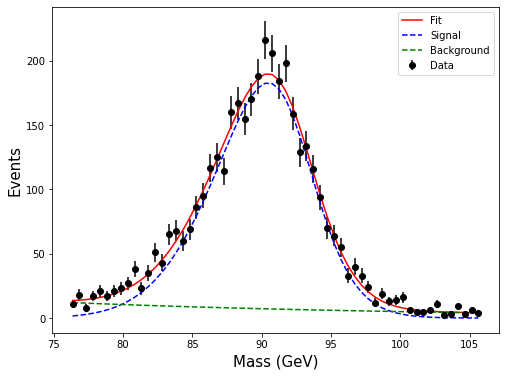

error value saved to eN_1hee1.txt
value saved to N_1hee1.txt


In [5]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import cauchy, norm

# Load histogram data
root_file_path = "mass_regionEE_hlt.root"
with uproot.open(root_file_path) as file:
    hist = file["h_mass_1hlt_EE_hist1;1"]
    hist_values, hist_edges = hist.to_numpy()

# Calculate x-data (bin centers) and normalize y-data
x_data = (hist_edges[:-1] + hist_edges[1:]) / 2
y_data = hist_values

# Re-bin the data to 60 bins
new_bin_count = 60
new_hist_values, new_hist_edges = np.histogram(
    x_data, bins=new_bin_count, weights=y_data
)
x_data = (new_hist_edges[:-1] + new_hist_edges[1:]) / 2  # Bin centers
y_data = new_hist_values
y_errors = np.sqrt(y_data)  # Recalculate errors

# Define the convoluted signal model (Breit-Wigner + Gaussian)
def convoluted_signal(x, m, gamma, mu, sigma):
    # Breit-Wigner (Cauchy PDF)
    bw = cauchy.pdf(x, loc=m, scale=gamma)
    # Gaussian (Normal distribution)
    gauss = norm.pdf(x, loc=mu, scale=sigma)
    # Convolution approximation (pointwise multiplication, normalize after)
    conv = bw * gauss
    conv /= np.sum(conv)  # Normalize over entire range
    return conv

# Exponential background model (with varying slope)
def exponential_background(x, a, b):
    # a: Exponential normalization (background yield)
    # b: Exponential slope (background decay)
    return a * np.exp(b * x)

# Define the complete fit function for both signal and background
def fit_function(x, m, gamma, mu, sigma, a, b, sig_yield):
    # Signal model
    signal = convoluted_signal(x, m, gamma, mu, sigma)
    signal *= sig_yield  # Scale signal by signal yield

    # Exponential background model (with varying slope)
    background = exponential_background(x, a, b)
    
    # Combine signal and background
    return signal + background

# Total number of events in the histogram
total_yield = np.sum(y_data)  
signal_fraction_guess = 0.95  # Increase signal fraction guess (e.g., 0.95 or 0.9)
signal_yield_guess = total_yield * signal_fraction_guess
background_yield_guess = total_yield * (1 - signal_fraction_guess)

# Initial Parameters (signal and background yield fixed)
initial_params = [
    91.1876,  # m: Breit-Wigner mass
    2.4952,   # gamma: Breit-Wigner width
    91.0,     # mu: Gaussian mean
    2.0,      # sigma: Gaussian standard deviation
    1.0,      # a: Exponential constant term (background normalization)
    -0.01,    # b: Exponential slope (background decay)
    signal_yield_guess,   # sig_yield: Signal yield
]

# Bounds for Parameters (background yield and slope are allowed to vary)
bounds = (
    [90, 0.5, 85, 0.1, 0.0, -0.5, 0],  # Lower bounds
    [94, 5.5, 94, 4.8, np.inf, 1.0, total_yield * 1.5]  # Upper bounds
)

# Fit the data
popt, pcov = curve_fit(
    fit_function, x_data, y_data, p0=initial_params, sigma=y_errors, bounds=bounds
)

# Extracting the fitted parameters
(m, gamma, mu, sigma, a, b, sig_yield) = popt

# Compute errors in the fit parameters
sig_yield_error = np.sqrt(pcov[6, 6])  # Error for sig_yield (7th parameter)
background_error = np.sqrt(pcov[4, 4])  # Error for background (5th parameter)

# Print the results
print(f"Signal Yield: {sig_yield:.2f} ± {sig_yield_error:.2f}")
print(f"Background Yield: {a:.2f} ± {background_error:.2f}")
print(f"Background Slope: {b:.2f} ± {np.sqrt(pcov[5, 5]):.2f}")

# Generate the signal and background components for plotting
signal = convoluted_signal(x_data, m, gamma, mu, sigma)
signal *= sig_yield

background = exponential_background(x_data, a, b)

# Generate the fit curve
fit = signal + background

# Compute the Chi-squared value
residuals = (y_data - fit) / y_errors  # Residuals
chi_squared = np.sum(residuals**2)  # Chi-squared value
dof = len(x_data) - len(popt)  # Degrees of freedom
chi_squared_dof = chi_squared / dof  # Chi-squared per dof

# Print Chi-squared and Degrees of Freedom
print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"Chi-squared per dof: {chi_squared_dof:.2f}")

# Diagnostic plot of the fit
plt.figure(figsize=(8, 6))
plt.errorbar(x_data, y_data, yerr=y_errors, fmt='o', label='Data', color='black')
plt.plot(x_data, fit, label='Fit', color='red')
plt.plot(x_data, signal, '--', label='Signal', color='blue')
plt.plot(x_data, background, '--', label='Background', color='green')
plt.xlabel("Mass (GeV)" , fontsize=15)
plt.ylabel("Events" , fontsize=15)
plt.legend()
plt.show()
with open("eN_1hee1.txt", "w") as file:
    file.write(f"{sig_yield_error}\n")
    print("error value saved to eN_1hee1.txt")
with open("N_1hee1.txt", "w") as file:
    file.write(f"{sig_yield}\n")
    print("value saved to N_1hee1.txt")

Signal Yield: 2977.35 ± 89.01
Background Yield: 281.66 ± 269.11
Background Slope: -0.04 ± 0.01
Chi-squared: 49.81
Degrees of Freedom: 53
Chi-squared per dof: 0.94


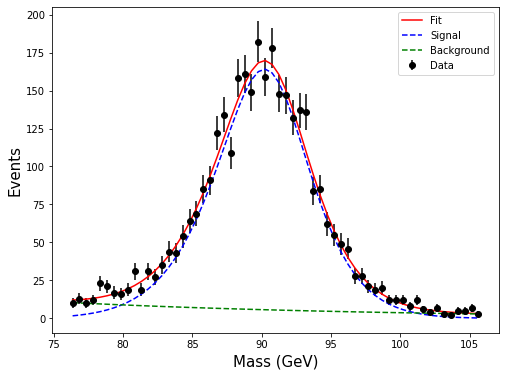

error value saved to eN_1hee2.txt
value saved to N_1hee2.txt


In [6]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import cauchy, norm

# Load histogram data
root_file_path = "mass_regionEE_hlt.root"
with uproot.open(root_file_path) as file:
    hist = file["h_mass_1hlt_EE_hist2;1"]
    hist_values, hist_edges = hist.to_numpy()

# Calculate x-data (bin centers) and normalize y-data
x_data = (hist_edges[:-1] + hist_edges[1:]) / 2
y_data = hist_values

# Re-bin the data to 60 bins
new_bin_count = 60
new_hist_values, new_hist_edges = np.histogram(
    x_data, bins=new_bin_count, weights=y_data
)
x_data = (new_hist_edges[:-1] + new_hist_edges[1:]) / 2  # Bin centers
y_data = new_hist_values
y_errors = np.sqrt(y_data)  # Recalculate errors

# Define the convoluted signal model (Breit-Wigner + Gaussian)
def convoluted_signal(x, m, gamma, mu, sigma):
    # Breit-Wigner (Cauchy PDF)
    bw = cauchy.pdf(x, loc=m, scale=gamma)
    # Gaussian (Normal distribution)
    gauss = norm.pdf(x, loc=mu, scale=sigma)
    # Convolution approximation (pointwise multiplication, normalize after)
    conv = bw * gauss
    conv /= np.sum(conv)  # Normalize over entire range
    return conv

# Exponential background model (with varying slope)
def exponential_background(x, a, b):
    # a: Exponential normalization (background yield)
    # b: Exponential slope (background decay)
    return a * np.exp(b * x)

# Define the complete fit function for both signal and background
def fit_function(x, m, gamma, mu, sigma, a, b, sig_yield):
    # Signal model
    signal = convoluted_signal(x, m, gamma, mu, sigma)
    signal *= sig_yield  # Scale signal by signal yield

    # Exponential background model (with varying slope)
    background = exponential_background(x, a, b)
    
    # Combine signal and background
    return signal + background

# Total number of events in the histogram
total_yield = np.sum(y_data)  
signal_fraction_guess = 0.95  # Increase signal fraction guess (e.g., 0.95 or 0.9)
signal_yield_guess = total_yield * signal_fraction_guess
background_yield_guess = total_yield * (1 - signal_fraction_guess)

# Initial Parameters (signal and background yield fixed)
initial_params = [
    91.1876,  # m: Breit-Wigner mass
    2.4952,   # gamma: Breit-Wigner width
    91.0,     # mu: Gaussian mean
    2.0,      # sigma: Gaussian standard deviation
    1.0,      # a: Exponential constant term (background normalization)
    -0.01,    # b: Exponential slope (background decay)
    signal_yield_guess,   # sig_yield: Signal yield
]

# Bounds for Parameters (background yield and slope are allowed to vary)
bounds = (
    [90, 0.5, 85, 0.1, 0.0, -0.5, 0],  # Lower bounds
    [94, 5.5, 94, 7.0, np.inf, 1.0, total_yield * 1.5]  # Upper bounds
)

# Fit the data
popt, pcov = curve_fit(
    fit_function, x_data, y_data, p0=initial_params, sigma=y_errors, bounds=bounds
)

# Extracting the fitted parameters
(m, gamma, mu, sigma, a, b, sig_yield) = popt

# Compute errors in the fit parameters
sig_yield_error = np.sqrt(pcov[6, 6])  # Error for sig_yield (7th parameter)
background_error = np.sqrt(pcov[4, 4])  # Error for background (5th parameter)

# Print the results
print(f"Signal Yield: {sig_yield:.2f} ± {sig_yield_error:.2f}")
print(f"Background Yield: {a:.2f} ± {background_error:.2f}")
print(f"Background Slope: {b:.2f} ± {np.sqrt(pcov[5, 5]):.2f}")

# Generate the signal and background components for plotting
signal = convoluted_signal(x_data, m, gamma, mu, sigma)
signal *= sig_yield

background = exponential_background(x_data, a, b)

# Generate the fit curve
fit = signal + background

# Compute the Chi-squared value
residuals = (y_data - fit) / y_errors  # Residuals
chi_squared = np.sum(residuals**2)  # Chi-squared value
dof = len(x_data) - len(popt)  # Degrees of freedom
chi_squared_dof = chi_squared / dof  # Chi-squared per dof

# Print Chi-squared and Degrees of Freedom
print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"Chi-squared per dof: {chi_squared_dof:.2f}")

# Diagnostic plot of the fit
plt.figure(figsize=(8, 6))
plt.errorbar(x_data, y_data, yerr=y_errors, fmt='o', label='Data', color='black')
plt.plot(x_data, fit, label='Fit', color='red')
plt.plot(x_data, signal, '--', label='Signal', color='blue')
plt.plot(x_data, background, '--', label='Background', color='green')
plt.xlabel("Mass (GeV)" , fontsize=15)
plt.ylabel("Events" , fontsize=15)
plt.legend()
plt.show()
with open("eN_1hee2.txt", "w") as file:
    file.write(f"{sig_yield_error}\n")
    print("error value saved to eN_1hee2.txt")
with open("N_1hee2.txt", "w") as file:
    file.write(f"{sig_yield}\n")
    print("value saved to N_1hee2.txt")

Signal Yield: 2529.20 ± 70.05
Background Yield: 90.26 ± 75.67
Background Slope: -0.03 ± 0.01
Chi-squared: 52.32
Degrees of Freedom: 53
Chi-squared per dof: 0.99


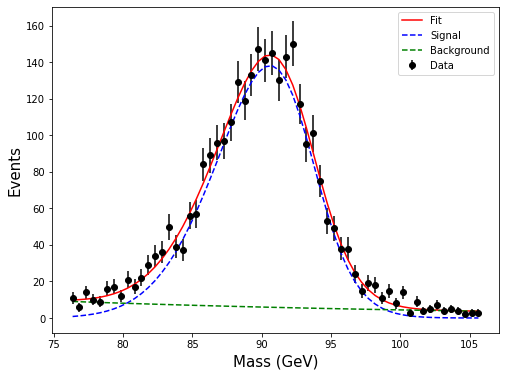

error value saved to eN_1hee3.txt
value saved to N_1hee3.txt


In [7]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import cauchy, norm

# Load histogram data
root_file_path = "mass_regionEE_hlt.root"
with uproot.open(root_file_path) as file:
    hist = file["h_mass_1hlt_EE_hist3;1"]
    hist_values, hist_edges = hist.to_numpy()

# Calculate x-data (bin centers) and normalize y-data
x_data = (hist_edges[:-1] + hist_edges[1:]) / 2
y_data = hist_values

# Re-bin the data to 60 bins
new_bin_count = 60
new_hist_values, new_hist_edges = np.histogram(
    x_data, bins=new_bin_count, weights=y_data
)
x_data = (new_hist_edges[:-1] + new_hist_edges[1:]) / 2  # Bin centers
y_data = new_hist_values
y_errors = np.sqrt(y_data)  # Recalculate errors

# Define the convoluted signal model (Breit-Wigner + Gaussian)
def convoluted_signal(x, m, gamma, mu, sigma):
    # Breit-Wigner (Cauchy PDF)
    bw = cauchy.pdf(x, loc=m, scale=gamma)
    # Gaussian (Normal distribution)
    gauss = norm.pdf(x, loc=mu, scale=sigma)
    # Convolution approximation (pointwise multiplication, normalize after)
    conv = bw * gauss
    conv /= np.sum(conv)  # Normalize over entire range
    return conv

# Exponential background model (with varying slope)
def exponential_background(x, a, b):
    # a: Exponential normalization (background yield)
    # b: Exponential slope (background decay)
    return a * np.exp(b * x)

# Define the complete fit function for both signal and background
def fit_function(x, m, gamma, mu, sigma, a, b, sig_yield):
    # Signal model
    signal = convoluted_signal(x, m, gamma, mu, sigma)
    signal *= sig_yield  # Scale signal by signal yield

    # Exponential background model (with varying slope)
    background = exponential_background(x, a, b)
    
    # Combine signal and background
    return signal + background

# Total number of events in the histogram
total_yield = np.sum(y_data)  
signal_fraction_guess = 0.95  # Increase signal fraction guess (e.g., 0.95 or 0.9)
signal_yield_guess = total_yield * signal_fraction_guess
background_yield_guess = total_yield * (1 - signal_fraction_guess)

# Initial Parameters (signal and background yield fixed)
initial_params = [
    91.1876,  # m: Breit-Wigner mass
    2.4952,   # gamma: Breit-Wigner width
    91.0,     # mu: Gaussian mean
    2.0,      # sigma: Gaussian standard deviation
    1.0,      # a: Exponential constant term (background normalization)
    -0.01,    # b: Exponential slope (background decay)
    signal_yield_guess,   # sig_yield: Signal yield
]

# Bounds for Parameters (background yield and slope are allowed to vary)
bounds = (
    [90, 0.5, 85, 0.1, 0.0, -0.5, 0],  # Lower bounds
    [94, 5.5, 94, 4.5, np.inf, 1.0, total_yield * 1.5]  # Upper bounds
)

# Fit the data
popt, pcov = curve_fit(
    fit_function, x_data, y_data, p0=initial_params, sigma=y_errors, bounds=bounds
)

# Extracting the fitted parameters
(m, gamma, mu, sigma, a, b, sig_yield) = popt

# Compute errors in the fit parameters
sig_yield_error = np.sqrt(pcov[6, 6])  # Error for sig_yield (7th parameter)
background_error = np.sqrt(pcov[4, 4])  # Error for background (5th parameter)

# Print the results
print(f"Signal Yield: {sig_yield:.2f} ± {sig_yield_error:.2f}")
print(f"Background Yield: {a:.2f} ± {background_error:.2f}")
print(f"Background Slope: {b:.2f} ± {np.sqrt(pcov[5, 5]):.2f}")

# Generate the signal and background components for plotting
signal = convoluted_signal(x_data, m, gamma, mu, sigma)
signal *= sig_yield

background = exponential_background(x_data, a, b)

# Generate the fit curve
fit = signal + background

# Compute the Chi-squared value
residuals = (y_data - fit) / y_errors  # Residuals
chi_squared = np.sum(residuals**2)  # Chi-squared value
dof = len(x_data) - len(popt)  # Degrees of freedom
chi_squared_dof = chi_squared / dof  # Chi-squared per dof

# Print Chi-squared and Degrees of Freedom
print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"Chi-squared per dof: {chi_squared_dof:.2f}")

# Diagnostic plot of the fit
plt.figure(figsize=(8, 6))
plt.errorbar(x_data, y_data, yerr=y_errors, fmt='o', label='Data', color='black')
plt.plot(x_data, fit, label='Fit', color='red')
plt.plot(x_data, signal, '--', label='Signal', color='blue')
plt.plot(x_data, background, '--', label='Background', color='green')
plt.xlabel("Mass (GeV)" , fontsize=15)
plt.ylabel("Events" , fontsize=15)
plt.legend()
plt.show()
with open("eN_1hee3.txt", "w") as file:
    file.write(f"{sig_yield_error}\n")
    print("error value saved to eN_1hee3.txt")
with open("N_1hee3.txt", "w") as file:
    file.write(f"{sig_yield}\n")
    print("value saved to N_1hee3.txt")

In [8]:
# eff cal for EE_hlt_hist1 #

import numpy as np

# Given data with uncertainties
Nsig1 =  3370.69 
Nsig1_error = 91.48
Nsig2 = 10392.20
Nsig2_error = 159.01

# Calculate efficiency
efficiency = (2*Nsig2) / ((2*Nsig2) + Nsig1)

# Partial derivatives
d_eta_d_Nsig1 = -Nsig2 / (Nsig1 + Nsig2)**2
d_eta_d_Nsig2 = 1 / (Nsig1 + Nsig2)

# Propagated uncertainty
efficiency_error = np.sqrt((d_eta_d_Nsig1 * Nsig1_error)**2 + (d_eta_d_Nsig2 * Nsig2_error)**2)

print(f"Efficiency_EE_hlt_hist1: {efficiency:.4f} ± {efficiency_error:.4f}")


Efficiency_EE_hlt_hist1: 0.8605 ± 0.0126


In [9]:
# eff cal for EE_hlt_hist2 #

import numpy as np

# Given data with uncertainties
Nsig1 = 2977.35
Nsig1_error = 80.44
Nsig2 =  9135.45
Nsig2_error = 142.85

# Calculate efficiency
efficiency = (2*Nsig2) / ((2*Nsig2) + Nsig1)

# Partial derivatives
d_eta_d_Nsig1 = -Nsig2 / (Nsig1 + Nsig2)**2
d_eta_d_Nsig2 = 1 / (Nsig1 + Nsig2)

# Propagated uncertainty
efficiency_error = np.sqrt((d_eta_d_Nsig1 * Nsig1_error)**2 + (d_eta_d_Nsig2 * Nsig2_error)**2)

print(f"Efficiency_EE_hlt_hist2: {efficiency:.4f} ± {efficiency_error:.4f}")


Efficiency_EE_hlt_hist2: 0.8599 ± 0.0128


In [10]:
# eff cal for EE_hlt_hist3 #

import numpy as np

# Given data with uncertainties
Nsig1 = 2529.20
Nsig1_error = 63.74
Nsig2 =  7624.64
Nsig2_error = 121.28

# Calculate efficiency
efficiency = (2*Nsig2) / ((2*Nsig2) + Nsig1)

# Partial derivatives
d_eta_d_Nsig1 = -Nsig2 / (Nsig1 + Nsig2)**2
d_eta_d_Nsig2 = 1 / (Nsig1 + Nsig2)

# Propagated uncertainty
efficiency_error = np.sqrt((d_eta_d_Nsig1 * Nsig1_error)**2 + (d_eta_d_Nsig2 * Nsig2_error)**2)

print(f"Efficiency_EE_hlt_hist3: {efficiency:.4f} ± {efficiency_error:.4f}")


Efficiency_EE_hlt_hist3: 0.8577 ± 0.0128


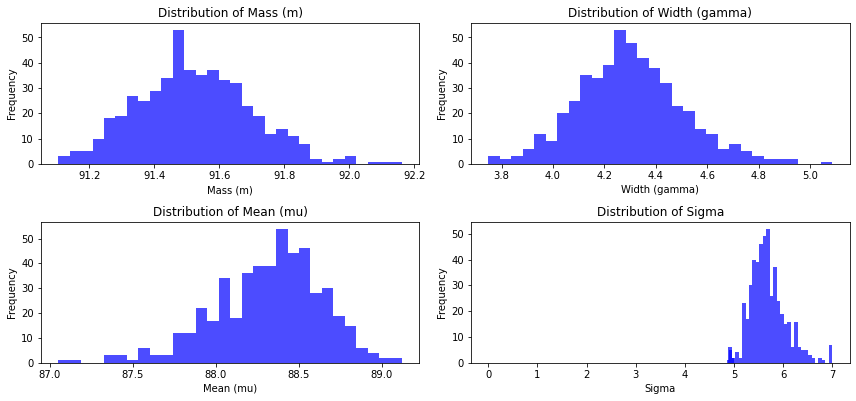

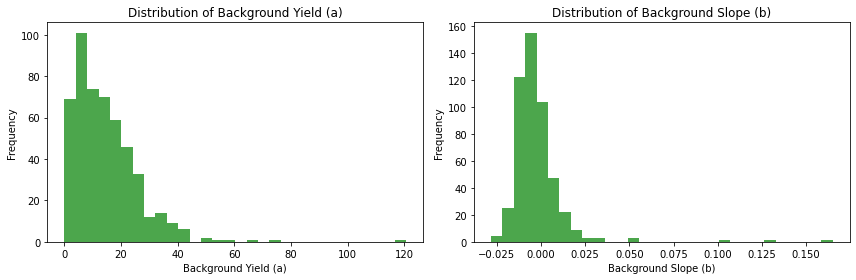

In [14]:
### best and final 1 ###

import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import cauchy, norm

# Load histogram data
root_file_path = "mass_regionEE_hlt.root"
with uproot.open(root_file_path) as file:
    hist = file["h_mass_2hlt_EE_hist1;1"] 
    hist_values, hist_edges = hist.to_numpy()

# Calculate x-data (bin centers) and normalize y-data
x_data = (hist_edges[:-1] + hist_edges[1:]) / 2
y_data = hist_values
y_errors = np.sqrt(y_data)  # Assume Poisson statistics for errors

# Define the convoluted signal model (Breit-Wigner + Gaussian)
def convoluted_signal(x, m, gamma, mu, sigma):
    bw = cauchy.pdf(x, loc=m, scale=gamma)
    gauss = norm.pdf(x, loc=mu, scale=sigma)
    conv = bw * gauss
    conv /= np.sum(conv)  # Normalize over entire range
    return conv

# Exponential background model (with varying slope)
def exponential_background(x, a, b):
    return a * np.exp(b * x)

# Define the complete fit function for both signal and background
def fit_function(x, m, gamma, mu, sigma, a, b, sig_yield):
    signal = convoluted_signal(x, m, gamma, mu, sigma)
    signal *= sig_yield
    background = exponential_background(x, a, b)
    return signal + background

# Total number of events in the histogram
total_yield = np.sum(y_data)
signal_fraction_guess = 0.95
signal_yield_guess = total_yield * signal_fraction_guess
background_yield_guess = total_yield * (1 - signal_fraction_guess)

# Initial Parameters
initial_params = [
    91.1876, 2.4952, 91.0, 2.0, 1.0, -0.01, signal_yield_guess
]

# Bounds for Parameters
bounds = (
    [90, 0.5, 85, 0.1, 0.0, -0.5, 0],
    [94, 5.5, 94, 7.0, np.inf, 1.0, total_yield * 1.5]
)

# Number of bootstrap iterations
n_bootstrap = 500

# Arrays to store fitted parameters
signal_params = []  # For signal-related parameters (m, gamma, mu, sigma, sig_yield)
background_params = []  # For background-related parameters (a, b)

# Perform bootstrapping
for _ in range(n_bootstrap):
    # Generate a resampled histogram with replacement
    resampled_y_data = np.random.poisson(y_data)  # Resample assuming Poisson statistics

    try:
        # Fit the resampled data
        popt_resampled, _ = curve_fit(
            fit_function, x_data, resampled_y_data, p0=initial_params, sigma=y_errors, bounds=bounds
        )
        
        # Store signal parameters
        signal_params.append(popt_resampled[:5])  # m, gamma, mu, sigma, sig_yield
        
        # Store background parameters
        background_params.append(popt_resampled[4:6])  # a, b
    
    except RuntimeError:
        # Skip fits that fail to converge
        continue

# Convert collected parameters to numpy arrays for easier indexing
signal_params = np.array(signal_params)
background_params = np.array(background_params)

# Plotting signal parameter distributions
plt.figure(figsize=(12, 8))
signal_labels = ["Mass (m)", "Width (gamma)", "Mean (mu)", "Sigma"]
for i, param in enumerate(signal_labels):
    plt.subplot(3, 2, i + 1)
    plt.hist(signal_params[:, i], bins=30, color='blue', alpha=0.7)
    if param == "Sigma":
        plt.hist(signal_params[:, i],range=(0,5), bins=100, color='blue', alpha=0.7)
    plt.xlabel(param)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {param}")
plt.tight_layout()
plt.show()

# Plotting background parameter distributions
plt.figure(figsize=(12, 4))
background_labels = ["Background Yield (a)", "Background Slope (b)"]
for i, param in enumerate(background_labels):
    plt.subplot(1, 2, i + 1)
    plt.hist(background_params[:, i], bins=30, color='green', alpha=0.7)
    plt.xlabel(param)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {param}")
plt.tight_layout()
plt.show()


Signal Yield: 10392.20 ± 159.01
Background Yield: 12.69 ± 9.94
2HLT efficiency : 0.7567 ± 0.0126
Background Slope: -0.01 ± 0.01
Chi-squared: 114.11
Degrees of Freedom: 113
Chi-squared per dof: 1.01


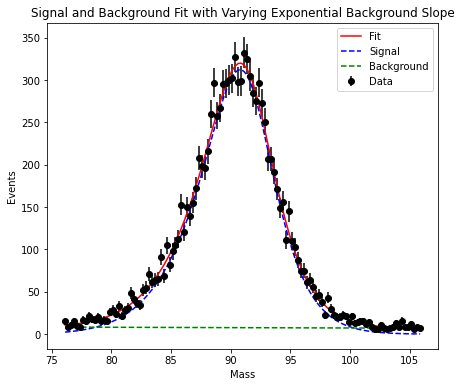

<Figure size 504x432 with 0 Axes>

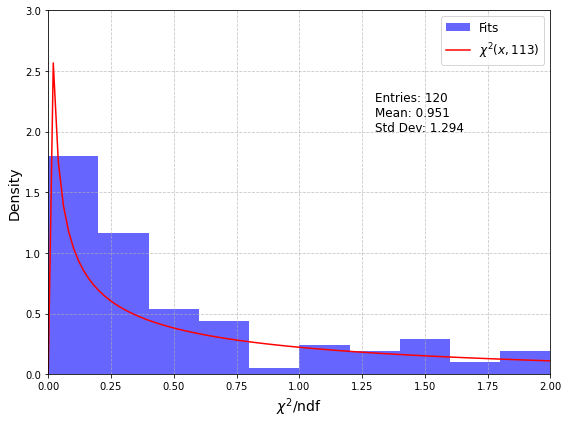

In [15]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import cauchy, norm, chi2

# Load histogram data
root_file_path = "mass_regionEE_hlt.root"
with uproot.open(root_file_path) as file:
    hist = file["h_mass_2hlt_EE_hist1;1"]
    hist_values, hist_edges = hist.to_numpy()

# Calculate x-data (bin centers) and normalize y-data
x_data = (hist_edges[:-1] + hist_edges[1:]) / 2
y_data = hist_values
y_errors = np.sqrt(y_data)  # Assume Poisson statistics for errors

# Define the convoluted signal model (Breit-Wigner + Gaussian)
def convoluted_signal(x, m, gamma, mu, sigma):
    # Breit-Wigner (Cauchy PDF)
    bw = cauchy.pdf(x, loc=m, scale=gamma)
    # Gaussian (Normal distribution)
    gauss = norm.pdf(x, loc=mu, scale=sigma)
    # Convolution approximation (pointwise multiplication, normalize after)
    conv = bw * gauss
    conv /= np.sum(conv)  # Normalize over entire range
    return conv

# Exponential background model (with varying slope)
def exponential_background(x, a, b):
    return a * np.exp(b * x)

# Define the complete fit function for both signal and background
def fit_function(x, m, gamma, mu, sigma, a, b, sig_yield):
    # Signal model
    signal = convoluted_signal(x, m, gamma, mu, sigma)
    signal *= sig_yield  # Scale signal by signal yield

    # Exponential background model (with varying slope)
    background = exponential_background(x, a, b)
    
    # Combine signal and background
    return signal + background

# Total number of events in the histogram
total_yield = np.sum(y_data)
signal_fraction_guess = 0.95
signal_yield_guess = total_yield * signal_fraction_guess
background_yield_guess = total_yield * (1 - signal_fraction_guess)

# Initial Parameters
initial_params = [
    91.1876,  # m: Breit-Wigner mass
    2.4952,   # gamma: Breit-Wigner width
    91.0,     # mu: Gaussian mean
    2.0,      # sigma: Gaussian standard deviation
    1.0,      # a: Exponential constant term
    -0.01,    # b: Exponential slope
    signal_yield_guess,  # sig_yield
]

# Bounds for Parameters
bounds = (
    [90, 0.5, 85, 0.1, 0.0, -0.5, 0],
    [94, 5.5, 94, 7.0, np.inf, 1.0, total_yield * 1.5]
)

# Fit the data
popt, pcov = curve_fit(
    fit_function, x_data, y_data, p0=initial_params, sigma=y_errors, bounds=bounds
)

# Extracting the fitted parameters
(m, gamma, mu, sigma, a, b, sig_yield) = popt

# Compute errors in the fit parameters
sig_yield_error = np.sqrt(pcov[6, 6])  # Error for sig_yield
background_error = np.sqrt(pcov[4, 4])  # Error for background

# Print the results
print(f"Signal Yield: {sig_yield:.2f} ± {sig_yield_error:.2f}")
print(f"Background Yield: {a:.2f} ± {background_error:.2f}")
print(f"2HLT efficiency : 0.7567 ± 0.0126")
print(f"Background Slope: {b:.2f} ± {np.sqrt(pcov[5, 5]):.2f}")

# Generate the signal and background components for plotting
signal = convoluted_signal(x_data, m, gamma, mu, sigma)
signal *= sig_yield

background = exponential_background(x_data, a, b)

# Generate the fit curve
fit = signal + background

# Compute the Chi-squared value
residuals = (y_data - fit) / y_errors  # Residuals
chi_squared = np.sum(residuals**2)  # Chi-squared value
dof = len(x_data) - len(popt)  # Degrees of freedom
chi_squared_dof = chi_squared / dof  # Chi-squared per dof

# Print Chi-squared and Degrees of Freedom
print(f"Chi-squared: {chi_squared:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"Chi-squared per dof: {chi_squared_dof:.2f}")

# Diagnostic plot of the fit
plt.figure(figsize=(7, 6))
plt.errorbar(x_data, y_data, yerr=y_errors, fmt='o', label='Data', color='black')
plt.plot(x_data, fit, label='Fit', color='red')
plt.plot(x_data, signal, '--', label='Signal', color='blue')
plt.plot(x_data, background, '--', label='Background', color='green')
plt.xlabel("Mass")
plt.ylabel("Events")
plt.legend()
plt.title("Signal and Background Fit with Varying Exponential Background Slope")
plt.show()

# Plot the Chi-squared/dof distribution
plt.figure(figsize=(7, 6))

# Compute normalized residuals^2
normalized_residuals = residuals**2  # Example placeholder

# Fit the Chi-squared distribution to the residuals
dof_fit = len(x_data) - len(popt)  # Degrees of freedom
params = chi2.fit(normalized_residuals)  # Fit Chi-squared distribution
mean = np.mean(normalized_residuals)
std_dev = np.std(normalized_residuals)
entries = len(normalized_residuals)

# Generate fitted Chi-squared distribution
x_chi2 = np.linspace(0, 2, 100)  # Adjust range
chi2_fitted = chi2.pdf(x_chi2, *params)

# Plot the normalized residuals histogram
plt.figure(figsize=(8, 6))
plt.hist(normalized_residuals, bins=10, range=(0, 2), density=True, alpha=0.6, color='blue', label='Fits')

# Overlay the theoretical Chi-squared PDF
plt.plot(x_chi2, chi2_fitted, 'r-', label=fr'$\chi^2(x, {dof_fit})$')

# Add CMS-style annotations
plt.text(1.3, 2.0, f"Entries: {entries}\nMean: {mean:.3f}\nStd Dev: {std_dev:.3f}", fontsize=12)
plt.xlabel(r'$\chi^2/\mathrm{ndf}$', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Add grid, legend, and adjust layout
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xlim(0, 2)
plt.ylim(0, 3)
plt.tight_layout()

Signal Yield: 14091.75 ± 210.84
Background Yield: 14.34 ± 13.45
2HLT efficiency : 0.7567 ± 0.0126
Background Slope: -0.00 ± 0.01
Chi-squared: 107.88
Degrees of Freedom: 113
Chi-squared per dof: 0.95


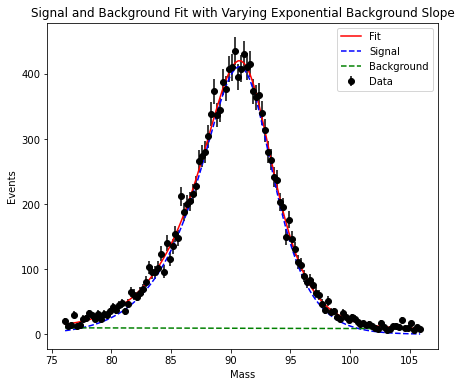

<Figure size 504x432 with 0 Axes>

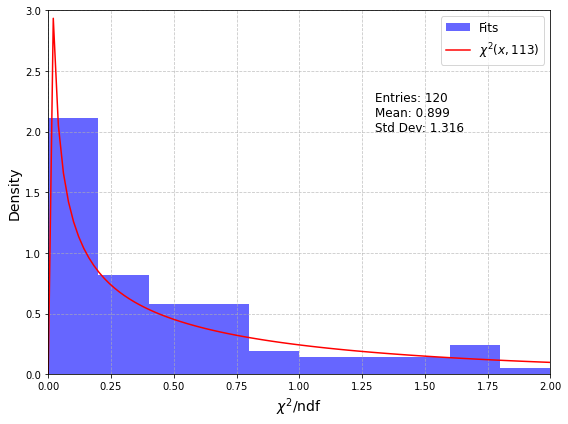

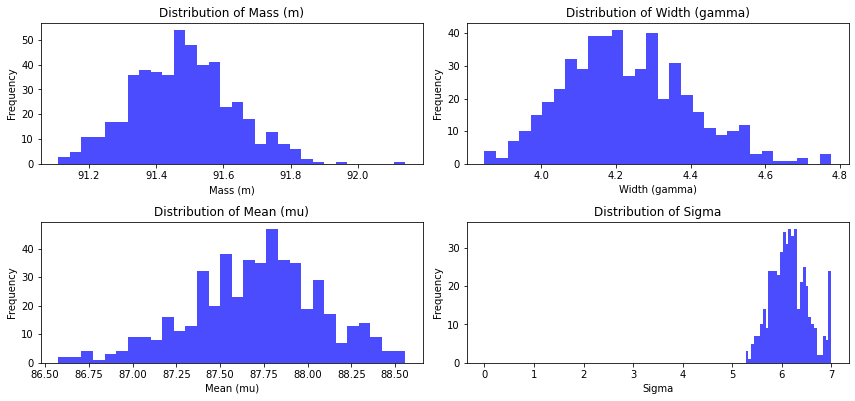

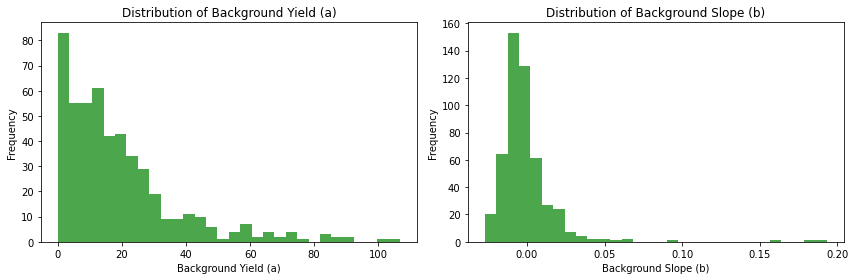

In [16]:
### best and final 1 ###

import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import cauchy, norm

# Load histogram data
root_file_path = "mass_regionEE.root"
with uproot.open(root_file_path) as file:
    hist = file["h_mass_2idpass_EE_hist1;1"] 
    hist_values, hist_edges = hist.to_numpy()

# Calculate x-data (bin centers) and normalize y-data
x_data = (hist_edges[:-1] + hist_edges[1:]) / 2
y_data = hist_values
y_errors = np.sqrt(y_data)  # Assume Poisson statistics for errors

# Define the convoluted signal model (Breit-Wigner + Gaussian)
def convoluted_signal(x, m, gamma, mu, sigma):
    bw = cauchy.pdf(x, loc=m, scale=gamma)
    gauss = norm.pdf(x, loc=mu, scale=sigma)
    conv = bw * gauss
    conv /= np.sum(conv)  # Normalize over entire range
    return conv

# Exponential background model (with varying slope)
def exponential_background(x, a, b):
    return a * np.exp(b * x)

# Define the complete fit function for both signal and background
def fit_function(x, m, gamma, mu, sigma, a, b, sig_yield):
    signal = convoluted_signal(x, m, gamma, mu, sigma)
    signal *= sig_yield
    background = exponential_background(x, a, b)
    return signal + background

# Total number of events in the histogram
total_yield = np.sum(y_data)
signal_fraction_guess = 0.95
signal_yield_guess = total_yield * signal_fraction_guess
background_yield_guess = total_yield * (1 - signal_fraction_guess)

# Initial Parameters
bounds = (
    [90, 0.5, 85, 0.1, 0.0, -0.5, 0],  # Lower bounds
    [94, 5.5, 94, 7.0, np.inf, 1.0, total_yield * 1.5]  # Upper bounds
)

# Fit the data
popt, pcov = curve_fit(
    fit_function, x_data, y_data, p0=initial_params, sigma=y_errors, bounds=bounds
)

# Number of bootstrap iterations
n_bootstrap = 500

# Arrays to store fitted parameters
signal_params = []  # For signal-related parameters (m, gamma, mu, sigma, sig_yield)
background_params = []  # For background-related parameters (a, b)

# Perform bootstrapping
for _ in range(n_bootstrap):
    # Generate a resampled histogram with replacement
    resampled_y_data = np.random.poisson(y_data)  # Resample assuming Poisson statistics

    try:
        # Fit the resampled data
        popt_resampled, _ = curve_fit(
            fit_function, x_data, resampled_y_data, p0=initial_params, sigma=y_errors, bounds=bounds
        )
        
        # Store signal parameters
        signal_params.append(popt_resampled[:5])  # m, gamma, mu, sigma, sig_yield
        
        # Store background parameters
        background_params.append(popt_resampled[4:6])  # a, b
    
    except RuntimeError:
        # Skip fits that fail to converge
        continue

# Convert collected parameters to numpy arrays for easier indexing
signal_params = np.array(signal_params)
background_params = np.array(background_params)

# Plotting signal parameter distributions
plt.figure(figsize=(12, 8))
signal_labels = ["Mass (m)", "Width (gamma)", "Mean (mu)", "Sigma"]
for i, param in enumerate(signal_labels):
    plt.subplot(3, 2, i + 1)
    plt.hist(signal_params[:, i], bins=30, color='blue', alpha=0.7)
    if param == "Sigma":
        plt.hist(signal_params[:, i],range=(0,5), bins=100, color='blue', alpha=0.7)
    plt.xlabel(param)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {param}")
plt.tight_layout()
plt.show()

# Plotting background parameter distributions
plt.figure(figsize=(12, 4))
background_labels = ["Background Yield (a)", "Background Slope (b)"]
for i, param in enumerate(background_labels):
    plt.subplot(1, 2, i + 1)
    plt.hist(background_params[:, i], bins=30, color='green', alpha=0.7)
    plt.xlabel(param)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {param}")
plt.tight_layout()
plt.show()
